In [1]:
%matplotlib inline
import matplotlib.style as style

import matplotlib.pyplot as plt
import numpy as np
import time
from tqdm import tqdm

import scqubits as scq
import qutip as qt

from PulseSequence import PulseSequence
from QSwitch import QSwitch

style.use('default')
plt.rcParams['figure.figsize'] = [6, 4]
default_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
scq.settings.PROGRESSBAR_DISABLED = True

In [2]:
hbar = 1
h = hbar*2*np.pi
qe = 1

# Unit conversions
MHz = 10.0**(-3)
GHz = 1.0
kHz = 10.0**(-6)
us = 10.0**3
ns = 1.0

In [ ]:

EJs = [21, 20, 22, 21.5]
ECs = [0.25, 0.35, 0.35, 0.2]
gs = [0.1, 0.2, 0.1]
cutoffs = [4,5,4,4]
isCavity = [False, False, False, False]

qram = QSwitch(
    EJs=EJs,
    ECs=ECs,
    gs=gs,
    cutoffs=cutoffs,
    isCavity=isCavity,
)
for n_psi0, psi0 in enumerate(psi0s):
    psi0_ids = qram.level_name_to_nums(psi0)
    for i1 in range(cutoffs[0]):
        for i2 in range(cutoffs[1]):
            for i3 in range(cutoffs[2]):
                for i4 in range(cutoffs[3]):
                    n_excite = np.abs(i1+i2+i3+i4-sum(psi0_ids))
                    if not 1 <= n_excite <= 2: continue
                    if n_excite == 1: # single photon transition with drive on 2nd qubit
                        if np.abs(i2-psi0_ids[1]) != 1: continue
                    elif n_excite == 2: # 2 photon transition with drive on 2nd qubit
                        if np.abs(i2-psi0_ids[1]) != 2: continue
                    psi = qram.level_nums_to_name([i1,i2,i3,i4])
                    if psi in psi0s[:n_psi0]: continue
                    if qram.get_Tpi(psi, psi0, 0.5) > 1000: continue # coupling too small to care
                    if not psi in psi0_to_psi_freqs[psi0]:
                        psi0_to_psi_freqs[psi0][psi] = []
                    
                    if n_excite == 1:
                        psi0_to_psi_freqs[psi0][psi].append(np.abs(qram.get_wd(psi0, psi))/2/np.pi)
                    else:
                        psi0_to_psi_freqs[psi0][psi].append(np.abs(0.5*qram.get_wd(psi0, psi))/2/np.pi)

In [3]:
transmon1_consts = dict(
    EC=0.25 * GHz,
    EJ=21.0 * GHz,
)

transmon2_consts = dict(
    EC=0.35 * GHz,
    EJ=20.0 * GHz,
)

transmon3_consts = dict(
    EC=0.35 * GHz,
    EJ=22.0 * GHz,
)

transmon4_consts = dict(
    EC=0.20 * GHz,
    EJ=21.5 * GHz,
)

q1_isCavity = False
q2_isCavity = False
q3_isCavity = False
q4_isCavity = False


transmon1 = scq.Transmon(
    **transmon1_consts, ng=0, ncut=110, truncated_dim=5
)

transmon2 = scq.Transmon(
    **transmon2_consts, ng=0, ncut=110, truncated_dim=5
)

transmon3 = scq.Transmon(
    **transmon3_consts, ng=0, ncut=110, truncated_dim=5
)

transmon4 = scq.Transmon(
    **transmon4_consts, ng=0, ncut=110, truncated_dim=5
)

In [4]:
evals_count = 5
cutoff = evals_count

evals1, evecs1 = transmon1.eigensys(evals_count=evals_count)
evals1 = evals1 - evals1[0] 

evals2, evecs2 = transmon2.eigensys(evals_count=evals_count)
evals2 = evals2 - evals2[0]

evals3, evecs3 = transmon3.eigensys(evals_count=evals_count)
evals3 = evals3 - evals3[0]

evals4, evecs4 = transmon4.eigensys(evals_count=evals_count)
evals4 = evals4 - evals4[0]

alpha1 = alpha2 = alpha3 = 0
if not q1_isCavity: alpha1 = evals1[2]-2*evals1[1]
if not q2_isCavity: alpha2 = evals2[2]-2*evals2[1]
if not q3_isCavity: alpha3 = evals3[2]-2*evals3[1]
if not q4_isCavity: alpha4 = evals4[2]-2*evals4[1]

print(evals1[1], evals2[1], evals3[1], evals4[1], alpha1, alpha2, alpha3, alpha4)

6.219955176682575 7.114505318471956 7.480762973458873 5.657631963057506 -0.27656660001468936 -0.3976349542294244 -0.3947192737967242 -0.21828295527838648


In [5]:
# g12 = 0.2
# g23 = 0.45
# g24 = 0.2
g12 = 0.1
g23 = 0.2
g24 = 0.1

In [6]:
a = qt.tensor(qt.destroy(cutoff), qt.qeye(cutoff), qt.qeye(cutoff), qt.qeye(cutoff)) # source
b = qt.tensor(qt.qeye(cutoff), qt.destroy(cutoff), qt.qeye(cutoff), qt.qeye(cutoff)) # switch
c = qt.tensor(qt.qeye(cutoff), qt.qeye(cutoff), qt.destroy(cutoff), qt.qeye(cutoff)) # out1
d = qt.tensor(qt.qeye(cutoff), qt.qeye(cutoff), qt.qeye(cutoff), qt.destroy(cutoff)) # out2
H_source    = 2*np.pi*(evals1[1]*a.dag()*a + 1/2*alpha1*a.dag()*a*(a.dag()*a - 1))
H_switch    = 2*np.pi*(evals2[1]*b.dag()*b + 1/2*alpha2*b.dag()*b*(b.dag()*b - 1))
H_out1      = 2*np.pi*(evals3[1]*c.dag()*c + 1/2*alpha3*c.dag()*c*(c.dag()*c - 1))
H_out2      = 2*np.pi*(evals4[1]*d.dag()*d + 1/2*alpha4*d.dag()*d*(d.dag()*d - 1))
H_int_12 = 2*np.pi*g12 * (a * b.dag() + a.dag() * b)
H_int_23 = 2*np.pi*g23 * (b * c.dag() + b.dag() * c)
H_int_24 = 2*np.pi*g24 * (b * d.dag() + b.dag() * d)

H = H_source + H_switch + H_out1 + H_out2 + H_int_12 + H_int_23 + H_int_24

esys = H.eigenstates()

# need a^\dag + a for fg <-> ge and b^\dag + b for gf <-> eg
# H_drive_12 = 2*np.pi* 1/2 * (a.dag()+a)
H_drive = 2*np.pi* 1/2 * (b.dag()+b)

In [7]:
# Map bare states of each transmon to dressed states in combined system
def find_dressed(ket_bare, H=H, esys=esys):
    if esys == None:
        esys = H.eigenstates()
    evals, evecs = esys
    best_overlap = 0
    best_state = -1
    for n, evec in enumerate(evecs):
        assert evec.shape == ket_bare.shape
        overlap = np.abs(ket_bare.overlap(evec))
        if overlap > best_overlap:
            best_overlap = overlap
            best_state = n
    # print(best_state)
    return best_state, evecs[best_state]

# Map dressed states to bare states
def find_bare(ket_dressed, cutoff=cutoff):
    best_overlap = 0
    best_state = None
    for i1 in range(cutoff):
        for i2 in range(cutoff):
            for i3 in range(cutoff):
                for i4 in range(cutoff):
                    psi_bare = make_bare([i1, i2, i3, i4], cutoff)
                    overlap = np.abs(ket_dressed.overlap(psi_bare))
                    if overlap > best_overlap:
                        best_overlap = overlap
                        best_state = [i1, i2, i3, i4]
    return best_state, make_bare(best_state, cutoff)

def make_bare(levels, cutoff=cutoff):
    prod = []
    lvl = dict(g=0, e=1, f=2, h=3, j=4)
    # print(levels)
    for level in levels:
        if isinstance(level, str): level = lvl[level]
        prod.append(qt.basis(cutoff, level))
    return qt.tensor(*prod)

def state(levels, H=H, cutoff=cutoff, esys=esys):
    return find_dressed(make_bare(levels, cutoff=cutoff), H=H, esys=esys)[1]

# Drive frequency b/w state1 and state2 (strings representing state) 
def get_wd(state1, state2, H=H, esys=esys):
    return qt.expect(H, state(state1, esys=esys)) - qt.expect(H, state(state2, esys=esys))

# Pi pulse length b/w state1 and state2 (strings representing state)
def get_Tpi(state1, state2, amp, H=H, H_drive=H_drive):
    psi0 = state(state1)
    psi1 = state(state2)
    g_eff = psi0.dag() * amp * H_drive * psi1 /2/np.pi
    g_eff = np.abs(g_eff[0][0][0])
    if g_eff == 0: return -1
    return 1/2/g_eff

# Add a pi pulse between state1 and state2 immediately after the previous pulse
def add_sequential_pi_pulse(seq, state1, state2, amp, t_pulse=None):
    if t_pulse == None: t_pulse = get_Tpi(state1, state2, amp=amp)
    seq.wait(seq.const_pulse(wd=get_wd(state1, state2), amp=amp, t_pulse=t_pulse))

#### MAKE SURE DRESSED STATES ARE MAPPED CORRECTLY, AT LEAST FOR <= 3 EXCITATIONS

In [11]:
seen = np.zeros((cutoff, cutoff, cutoff, cutoff))
evals, evecs = esys
for n, evec in enumerate(tqdm(evecs)):
    i = find_bare(evec)[0]
    seen[i[0], i[1], i[2], i[3]] += 1

for i1 in range(cutoff):
    for i2 in range(cutoff):
        for i3 in range(cutoff):
            for i4 in range(cutoff):
                assert seen[i1,i2,i3,i4] == 1 or i1+i2+i3+i4 > 3, f'Mapped dressed state to {[i1,i2,i3,i4]} {seen[i1,i2,i3,i4]} times!!!!'
print("Good enough for dressed states mappings.")

100%|██████████| 625/625 [02:13<00:00,  4.67it/s]

Good enough for dressed states mappings.


In [24]:
times = np.linspace(0, 1200, 400)
# times = np.linspace(0, 500, 500)
t_rise = 1 # ns

seq = PulseSequence(start_time=0)
add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.05)
add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.02)
add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.02)
add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.05)
add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.08)

# add_sequential_pi_pulse(seq, 'eggg', 'gfgg', amp=0.05)
# add_sequential_pi_pulse(seq, 'gfgg', 'ggeg', amp=0.02)
# add_sequential_pi_pulse(seq, 'eegg', 'eggg', amp=0.02)
# add_sequential_pi_pulse(seq, 'gfgg', 'ggge', amp=0.08)

# seq.wait(seq.const_pulse(wd=get_wd('eggg', 'gfgg'), amp=0.02, t_pulse=57.0470))
# seq.wait(seq.const_pulse(wd=get_wd('gfgg', 'ggeg'), amp=0.15, t_pulse=105.7047))
# seq.wait(seq.const_pulse(wd=get_wd('eegg', 'eggg'), amp=0.05, t_pulse=110.7383))
# seq.wait(seq.const_pulse(wd=get_wd('eggg', 'gfgg'), amp=0.02, t_pulse=1000))
# seq.wait(seq.const_pulse(wd=get_wd('gfgg', 'ggge'), amp=0.1, t_pulse=87.2483))

In [25]:
H_solver = [H]

for pulse in seq.get_pulse_seq():
    H_solver.append([H_drive, pulse])

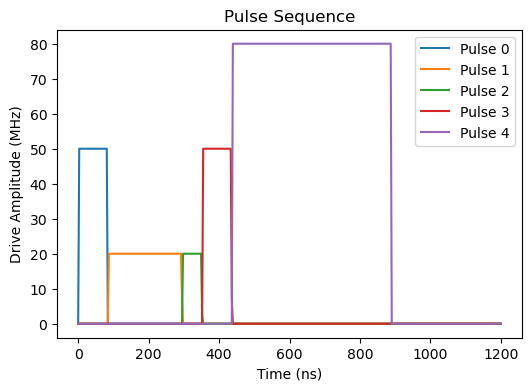

In [26]:
envelope_seq = seq.get_envelope_seq()
for i in range(len(envelope_seq)):
    plt.plot(times, [envelope_seq[i](t)/MHz for t in times], label=f'Pulse {i}')
plt.xlabel('Time (ns)')
plt.ylabel('Drive Amplitude (MHz)')
plt.title('Pulse Sequence')
plt.legend()
plt.show()

In [27]:
# incl_dissipation = True
incl_dissipation = False

T1 = 60e3 # ns
T2 = 30e3 # ?

T1 = 10e3

c_ops = [
    np.sqrt(1/T1)*state('gggg')*state('eggg').dag(),
    np.sqrt(1/T1)*state('gggg')*state('gegg').dag(),
    np.sqrt(1/T1)*state('gggg')*state('ggeg').dag(),
    np.sqrt(1/T1)*state('gggg')*state('ggge').dag(),
]

In [30]:
# psi0_name = 'eggg'
# psi0_name = 'gfgg'
# psi0_name = 'eegg'
# psi0_name = 'ggeg'
# psi0_name = 'ggge'

# psi0 = state(psi0_name)
psi0 = 1/np.sqrt(3) * state('eggg') + np.sqrt(2/3) * state('eegg') # QRAM start
# psi0 = 1/np.sqrt(2) * state('eegg') + 1/np.sqrt(2) * state('ggeg')

if incl_dissipation:
    result = qt.mesolve(H_solver, psi0, times, c_ops, progress_bar=True, options=qt.Options(nsteps=10000)).states
else: result = qt.mesolve(H_solver, psi0, times, progress_bar=True, options=qt.Options(nsteps=10000)).states

10.0%. Run time:  32.19s. Est. time left: 00:00:04:49
20.0%. Run time:  64.33s. Est. time left: 00:00:04:17
30.0%. Run time:  96.77s. Est. time left: 00:00:03:45
40.0%. Run time: 131.13s. Est. time left: 00:00:03:16
50.0%. Run time: 165.65s. Est. time left: 00:00:02:45
60.0%. Run time: 199.74s. Est. time left: 00:00:02:13
70.0%. Run time: 234.06s. Est. time left: 00:00:01:40
80.0%. Run time: 268.15s. Est. time left: 00:00:01:07
90.0%. Run time: 302.59s. Est. time left: 00:00:00:33
Total run time: 335.83s


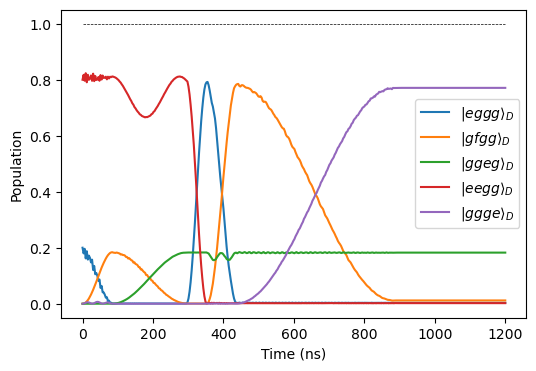

In [31]:
plt.plot(times, [np.abs(state('eggg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|eggg\rangle_D$')
plt.plot(times, [np.abs(state('gfgg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|gfgg\rangle_D$')
plt.plot(times, [np.abs(state('ggeg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|ggeg\rangle_D$')
plt.plot(times, [np.abs(state('eegg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|eegg\rangle_D$')
plt.plot(times, [np.abs(state('ggge').overlap(result[t]))**2 for t in range(len(times))], label=r'$|ggge\rangle_D$')
# plt.plot(times, [np.abs(state('gggg').overlap(result[t]))**2 for t in range(len(times))], label=r'$|gggg\rangle_D$')

# plt.plot(times, [np.abs(state('geeg').overlap(result[t]))**2 for t in range(len(times))], 'k--', label=r'$|geeg\rangle_D$')
# plt.plot(times, [np.abs(state('efgg').overlap(result[t]))**2 for t in range(len(times))], 'k-.', label=r'$|efgg\rangle_D$')

# lvls = ['g', 'e', 'f', 'h', 'j']
# for i1 in range(cutoff):
#     for i2 in tqdm(range(cutoff)):
#         for i3 in range(cutoff):
#             for i4 in range(cutoff):
# #                 print(lvls[i1]+lvls[i2]+lvls[i3]+lvls[i4])
#                 plt.plot(times, 
#                          [np.abs(
#                              state(lvls[i1]+lvls[i2]+lvls[i3]+lvls[i4]).overlap(result[t]))**2 for t in range(len(times))],
#                          label=f'{i1}{i2}{i3}{i4}')

plt.plot(times, [1]*len(times), 'k--', linewidth=0.5)
plt.legend()
# plt.xlim(750, 1000)
plt.xlabel('Time (ns)')
plt.ylabel('Population')
# plt.title(r'$\psi_0=|$'+psi0_name+r'$\rangle$')
plt.show()

In [32]:
T = 900 # ns

sum_psi = 0
T = np.argmin(np.abs(times-T))
lvls = ['g', 'e', 'f', 'h', 'j']
for i1 in range(cutoff):
    for i2 in range(cutoff):
        for i3 in range(cutoff):
            for i4 in range(cutoff):
                sum_psi += np.abs(state(lvls[i1]+lvls[i2]+lvls[i3]+lvls[i4]).overlap(result[T]))**2
print('Sum probabilities:', sum_psi)
print("Non-zero levels:")
for i1 in range(cutoff):
    for i2 in range(cutoff):
        for i3 in range(cutoff):
            for i4 in range(cutoff):
                prob = np.abs(state(lvls[i1]+lvls[i2]+lvls[i3]+lvls[i4]).overlap(result[T]))**2
                if prob > 0.01: print(lvls[i1]+lvls[i2]+lvls[i3]+lvls[i4])

Sum probabilities: 1.0068896232127242
Non-zero levels:
ggge
ggeg
gegg
gfgg
egeg


In [12]:
print('want', get_wd('eggg', 'eegg')/2/np.pi)
print('resonant to', get_wd('ggeg', 'geeg')/2/np.pi)
print('2 photon transition to', get_wd('eggg', 'efgg')/2/np.pi)

want -6.512665194861
resonant to -6.5299537518856825
2 photon transition to -13.03256106742545
